In [3]:
pip show keras

Name: keras
Version: 3.4.1
Summary: Multi-backend Keras.
Home-page: https://github.com/keras-team/keras
Author: Keras team
Author-email: keras-users@googlegroups.com
License: Apache License 2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: absl-py, h5py, ml-dtypes, namex, numpy, optree, packaging, rich
Required-by: tensorflow


In [4]:
pip show tensorflow


Name: tensorflow
Version: 2.17.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, libclang, ml-dtypes, numpy, opt-einsum, packaging, protobuf, requests, setuptools, six, tensorboard, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: dopamine_rl, tf_keras


In [9]:
!pip show nltk



Name: nltk
Version: 3.8.1
Summary: Natural Language Toolkit
Home-page: https://www.nltk.org/
Author: NLTK Team
Author-email: nltk.team@gmail.com
License: Apache License, Version 2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: click, joblib, regex, tqdm
Required-by: textblob


In [6]:
import pandas as pd
import re
import numpy as np
import nltk
from nltk.corpus import stopwords
import seaborn as sns
from tqdm import tqdm
from numpy import array, zeros, asarray
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import pickle

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer, one_hot
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, LSTM, Embedding, Dropout, Activation
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Cargar el dataset
df = pd.read_csv('Suicide_Detection.csv')
df = df.drop(['Unnamed: 0'], axis=1)
df

,text,class
0,Ex Wife Threatening SuicideRecently I left my ...,suicide
1,Am I weird I don't get affected by compliments...,non-suicide
2,Finally 2020 is almost over... So I can never ...,non-suicide
3,i need helpjust help me im crying so hard,suicide
4,"I’m so lostHello, my name is Adam (16) and I’v...",suicide
...,...,...
232069,If you don't like rock then your not going to ...,non-suicide
232070,You how you can tell i have so many friends an...,non-suicide
232071,pee probably tastes like salty tea😏💦‼️ can som...,non-suicide
232072,The usual stuff you find hereI'm not posting t...,suicide


In [11]:
# Descargar stopwords
nltk.download('stopwords')

def limpieza(texto):
    texto = texto.lower()
    texto = re.sub(r'\\[a-z]', ' ', texto)
    texto = re.sub(r'[^a-z]', ' ', texto)
    texto = re.sub(r'\s+[a-z]\s+', ' ', texto)
    texto = re.sub(r'\s+', ' ', texto)
    patern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
    texto = patern.sub('', texto)
    texto = texto.strip()
    return texto

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [13]:

# Limpiar los textos
texto_lista = list(df['text'])
lista_limpia = []
for texto in tqdm(texto_lista):
    lista_limpia.append(limpieza(texto))

df['text'] = lista_limpia


100%|██████████| 232074/232074 [05:00<00:00, 771.02it/s] 


In [14]:
df

,text,class
0,ex wife threatening suiciderecently left wife ...,suicide
1,weird get affected compliments coming someone ...,non-suicide
2,finally almost never hear bad year ever swear ...,non-suicide
3,need helpjust help im crying hard,suicide
4,losthello name adam struggling years afraid pa...,suicide
...,...,...
232069,like rock going get anything go https musictas...,non-suicide
232070,tell many friends lonely everything deprived p...,non-suicide
232071,pee probably tastes like salty tea someone dra...,non-suicide
232072,usual stuff find herei posting sympathy pity k...,suicide


In [16]:
# Codificar las etiquetas
le = LabelEncoder()
df['class'] = le.fit_transform(df['class'])

# Tokenización
token = Tokenizer()
token.fit_on_texts(lista_limpia)

vocab = len(token.word_index) + 1

# Convertir los textos a secuencias
sequences = token.texts_to_sequences(lista_limpia)

# Asegurarse de que todas las secuencias son listas de enteros
for i in range(len(sequences)):
    sequences[i] = list(map(int, sequences[i]))

# Padding de secuencias
longitud_maxima = 100
X = pad_sequences(sequences, maxlen=longitud_maxima, padding='post')

X = np.array(X)
y = np.array(df['class'])

In [17]:

# Cargar los embeddings preentrenados de GloVe
diccionario = dict()
with open('glove.6B.100d.txt', encoding='utf-8') as gloVe:
    for line in tqdm(gloVe):
        valor = line.split()
        word = valor[0]
        vector = np.asarray(valor[1:], 'float32')
        diccionario[word] = vector

# Crear la matriz de embeddings
matriz_embedding = zeros((vocab, 100))
for palabra, indice in token.word_index.items():
    vector_embedding = diccionario.get(palabra)
    if vector_embedding is not None:
        matriz_embedding[indice] = vector_embedding



400000it [00:18, 21701.09it/s]


In [21]:
vocab

150797

In [18]:
matriz_embedding.shape

(150797, 100)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/6
1625/1625 ━━━━━━━━━━━━━━━━━━━━ 346s 210ms/step - accuracy: 0.7081 - loss: 0.5478 - val_accuracy: 0.9008 - val_loss: 0.2555
Epoch 2/6
1625/1625 ━━━━━━━━━━━━━━━━━━━━ 383s 236ms/step - accuracy: 0.9015 - loss: 0.2689 - val_accuracy: 0.9161 - val_loss: 0.2128
Epoch 3/6
1625/1625 ━━━━━━━━━━━━━━━━━━━━ 372s 229ms/step - accuracy: 0.9180 - loss: 0.2237 - val_accuracy: 0.9249 - val_loss: 0.2055
Epoch 4/6
1625/1625 ━━━━━━━━━━━━━━━━━━━━ 391s 235ms/step - accuracy: 0.9248 - loss: 0.2041 - val_accuracy: 0.9315 - val_loss: 0.1925
Epoch 5/6
1625/1625 ━━━━━━━━━━━━━━━━━━━━ 346s 213ms/step - accuracy: 0.9298 - loss: 0.1910 - val_accuracy: 0.9344 - val_loss: 0.1792
Epoch 6/6
1625/1625 ━━━━━━━━━━━━━━━━━━━━ 381s 212ms/step - accuracy: 0.9343 - loss: 0.1802 - val_accuracy: 0.9336 - val_loss: 0.1887
2176/2176 ━━━━━━━━━━━━━━━━━━━━ 51s 23ms/step


              precision    recall  f1-score   support

           0       0.94      0.92      0.93     34914
           1       0.92      0.94      0.93   

NameError: name 'ConfusionMatrixDisplay' is not defined

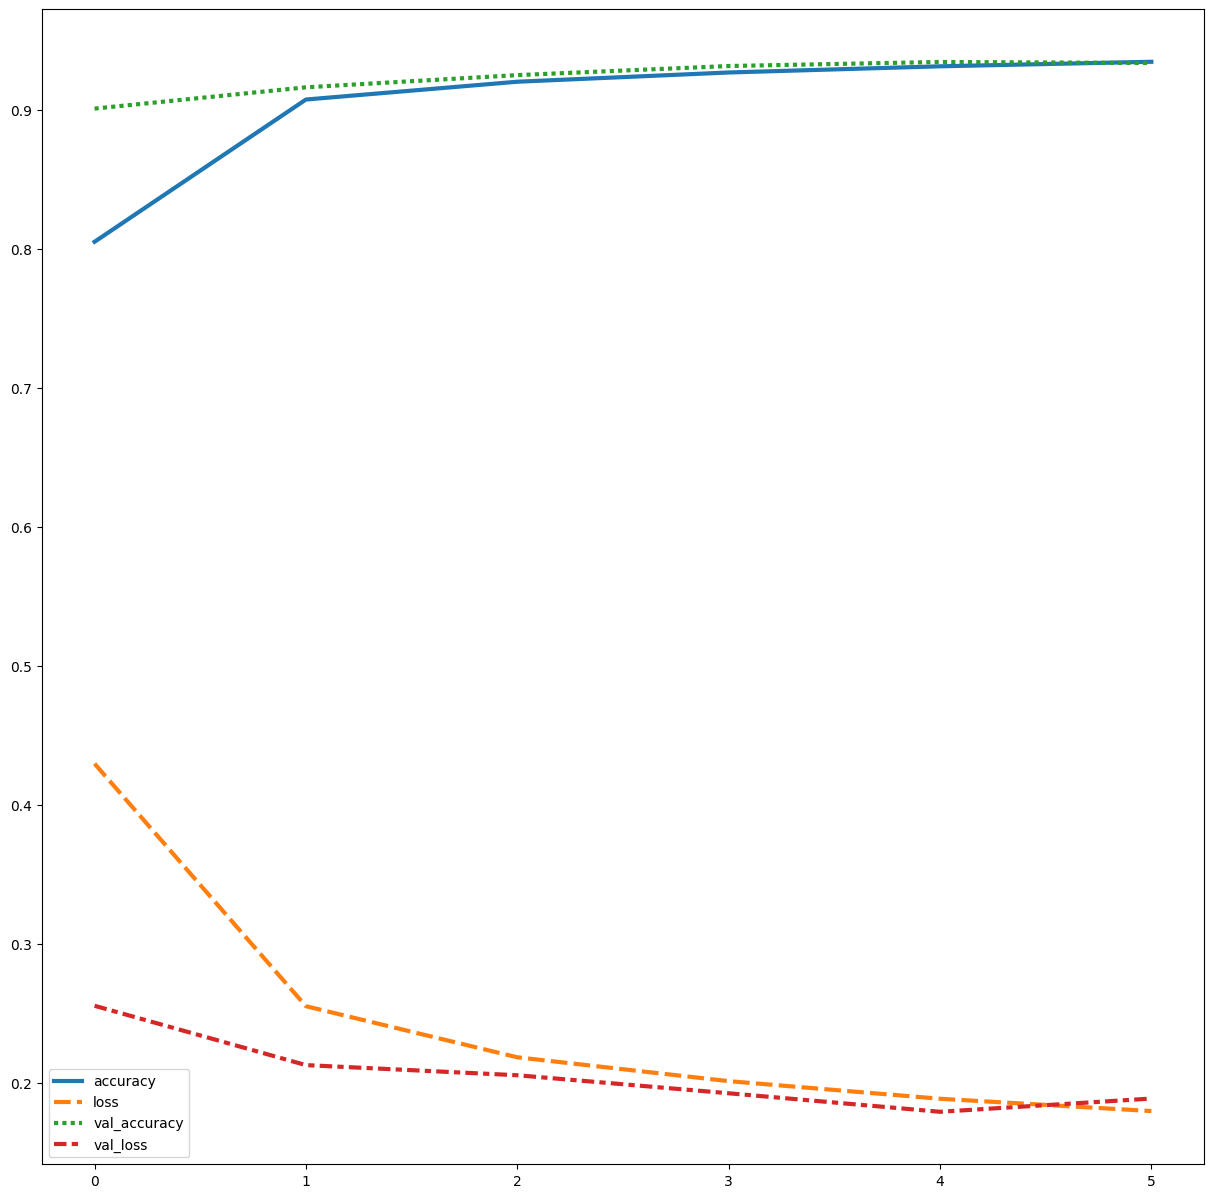

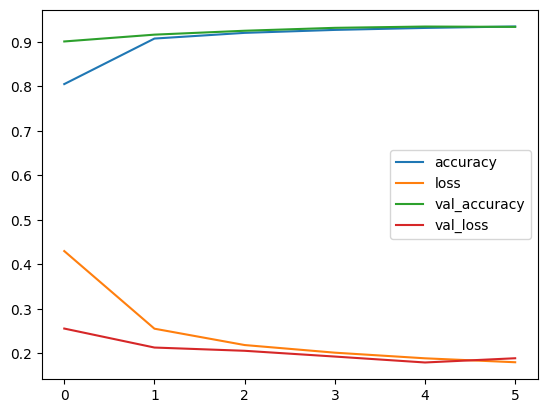

In [22]:


def crear_modelo(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1200, test_size=0.3)
    red_neuronal = Sequential()
    red_neuronal.add(Embedding(vocab, 100, weights=[matriz_embedding], input_length=longitud_maxima, trainable=False))
    red_neuronal.add(LSTM(64))
    red_neuronal.add(Dense(32, activation='relu'))
    red_neuronal.add(Dropout(0.5))
    red_neuronal.add(Dense(12, activation='relu'))
    red_neuronal.add(Dropout(0.5))
    red_neuronal.add(Dense(6, activation='relu'))
    red_neuronal.add(Dense(1, activation='sigmoid'))

    red_neuronal.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    red_neuronal.fit(X_train, y_train, epochs=6, batch_size=100, validation_data=(X_test, y_test))

    loss = pd.DataFrame(red_neuronal.history.history)
    plt.figure(figsize=(15, 15))
    sns.lineplot(data=loss, lw=3)
    loss.plot()
    return red_neuronal, X_train, X_test, y_train, y_test

red_neu, X_trai, x_test, y_train, y_test = crear_modelo(X, y)

# Evaluación del modelo
y_pred_test = red_neu.predict(x_test)
y_pred_test = y_pred_test > 0.5
print(f"\n")
print(classification_report(y_test, y_pred_test))
test_matrix = confusion_matrix(y_test, y_pred_test)
print(test_matrix)

y_pred_train = red_neu.predict(X_trai)
y_pred_train = y_pred_train > 0.5
print(f"\n")
print(classification_report(y_train, y_pred_train))
train_matrix = confusion_matrix(y_train, y_pred_train)
print(train_matrix)

class_labels = ['Not Suicide', 'Suicide']

disp_train = ConfusionMatrixDisplay(confusion_matrix=train_matrix, display_labels=class_labels)
disp_test = ConfusionMatrixDisplay(confusion_matrix=test_matrix, display_labels=class_labels)

fig, axs = plt.subplots(1, 2, figsize=(16, 6))
disp_train.plot(ax=axs[0], cmap='YlGnBu', colorbar=False)
axs[0].set_title('Train Confusion Matrix')
disp_test.plot(ax=axs[1], cmap='YlGnBu', colorbar=False)
axs[1].set_title('Test Confusion Matrix')
plt.tight_layout()
plt.show()



In [24]:
# Guardar el modelo de Keras
red_neu.save('depresion_model.h5')

# Guardar el tokenizador y la matriz de embeddings usando pickle
with open('tokenizer.pkl', 'wb') as handle:
    pickle.dump(token, handle)

with open('embedding_matrix.pkl', 'wb') as handle:
    pickle.dump(matriz_embedding, handle)